# Tutorial 2: SchNet Arquitecture with TensorFlow libraries

Para esta parte de los tutoriales nos basamos en la implementacion del libro **"deep learning for molecules & materials" de Andrew D. White ([White, 2021](https://doi.org/10.33011/livecoms.3.1.1499).)**

En este notebook se calculara la energia G (Energia libre de solvatacion) haciendo uso del dataset QM9 ([Ramakrishnan et al., 2014](https://doi.org/10.1063/1.5019779)) y la arquitectura SchNet ([K. T. Schütt et al., 2018](https://doi.org/10.1063/1.5019779)). Esta arquitectura se basa principalmente en la representacion de las moleculas como _grafos_ , en el tutorial anterior se mostro un ejemplo con redes densas o FCNN donde a pesar de que no se profundizo, es imprescindible tener **features o descriptores** de la molecula, de forma de generar un vector de features para predecir el output deseado.

Pensando un paso hacia atras, la definicion de feature en una molecula no es _directa_. Es posible definir diversas caracteristicas de una molecula, las cuales a priori no necesariamente ayudaran a mejorar o no el modelo, y en general seria mucho mas interesante operar directamente con la informacion, sin necesidad de preprocesar features. De aqui es la necesidad de utilizar grafos, que como se explicara a continuacion pueden ser una _buena_ representacion de una molecula





## Qué es un grafo?. 

Considerando un grafo dado por el siguiente esquema ([Peter W. Battaglia et al., 2019](https://arxiv.org/pdf/1806.01261))

![](/home/ian/Desktop/ML4molecularSims/Notebooks/2_SchNet_TensorFlow/imgs/grafo.png)

Es posible relacionar los nodos (nodes) $\mathbf{v}_i$ de este grafo con los atomos y los enlaces (edges) con los enlaces que existen en una molecula. En general el concepto de grafo es mas general que una molecula porque de las ultimas se conocen reglas a priori que se cumplen, como que los enlaces no poseen una direccion o que un atomo no se puede enlanzar consigo mismo.

De esta representacion entonces los nodos son los vectores $\mathbf{v}_i$ que poseen los features de cada uno de los atomos (por ejemplo carga, elemento, masa, etc), $e_k$ es el enlace entre atomos el cual depende del sender (emisor) $\mathbf{v}_{sk}$ y del receiver (receptor) $\mathbf{v}_{rk}$ y una propiedad global del grafo $u$. Un concepto importante que introducen la representacion en grafos es la equivarianza e invarianza, las cuales matematicamente se pueden entender como las siguientes definiciones

\begin{align*}
f(g(x)) &= g'f(x) \quad \quad &\text{Equivarianza} \\
f(g(x)) &= f(x) \quad \quad &\text{Invarianza}
\end{align*}

En terminos sencillos equivarianza significa que un cambio en la entrada $g$, produce un cambio proporcional en la salida $g'$, en cambio invarianza un cambio en la entrada, no produce ningun cambio en la salida. 

Un ejemplo sencillo de invarianza es la magnitud de un vector, el cual es invariante al sistema de coordenadas el cual se escoja, uno de equivarianza  es el cambio en la direccion de un vector por rotacion, donde hay un cambio en esta, pero es proporcional al angulo que se decidio rotar el vector.


## Como introducir los grafos a las redes neuronales?

Los grafos cambian la forma como se trabajan las redes, en si las operaciones dentro de una GNN (Graph Neural Network) se pueden esquematizar por medio de las ecuaciones de Battaglia ([Peter W. Battaglia et al., 2019](https://arxiv.org/pdf/1806.01261)), las cuales identifican 3 operaciones principales de actualizacion de valores dentro de la red (`update`)

\begin{aligned}
e'_k &= \phi^e \left(e_k, \mathbf{v}_{r_k}, \mathbf{v}_{s_k}, \mathbf{u}\right) \\
\mathbf{v}'_i &= \phi^v \left(\mathbf{e}'_i, \mathbf{v}_i, \mathbf{u}\right) \\
\mathbf{u}' &= \phi^u \left(\mathbf{e}', \mathbf{v}', \mathbf{u}\right)
\end{aligned}
La primera operacion va relacionado a las **conexiones** entre nodos, donde influye su valor anterior $e_k$, los valores de los nodos vecinos y la propiedad global

La segunda operacion va relacionado a los **nodos**, donde depende del valor del nodo, de los enlaces que tiene y la propiedad global del grafo

La tercera operacion es sobre la **propiedad global**, y depende de los nodos y conexiones de todo el grafo.

Ademas de operaciones de actualizacion, existen las operaciones de agregacion `aggregation`, donde el superindice indica hacia que ...
\begin{aligned}
\mathbf{e}'_i &= \rho^{e \rightarrow v} \left(E'_i\right) \\
\mathbf{e}' &= \rho^{e \rightarrow u} \left(E'\right) \\
\mathbf{v}' &= \rho^{v \rightarrow u} \left(V'\right)
\end{aligned}

Donde se considera los siguientes subconjuntos $ E'_i = \{(e_k, r_k, s_k)\}_{r_k=i, k=1:N_e} $, $ V' = \{\mathbf{v}'_i\}_{i=1:N_v} $, and $E' = \bigcup_i E'_i = \{(e'_k, r_k, s_k)\}_{k=1:N_e} $.


La arquitectura **SchNet**, se encuentra esquematizada por la siguiente figura

![](/home/ian/Desktop/ML4molecularSims/Notebooks/2_SchNet_TensorFlow/imgs/Schnet_arq.png)

Esta red posee las siguientes bloques dentro de una capa de interaccion (interaction)

* **Embedding**: Se transforma una descripcion discreta como los numeros atomicos, por una descripcion continua de $N$ canales la cual sera entrenada a cada iteracion
* **Atom-wise**: Corresponde a una operacion lineal del tipo  $\mathbf{x}^* = \mathbf{x}\mathbf{W} + \mathbf{b}$, donde en el caso de los grafos se multiplica cada $\mathbf{v}_i$ por el mismo $\mathbf{W}$
* **Shifted-Softplus**: Funcion de activacion no lineal, en este caso la eleccion de esta funcion es debido a que posee es una funcion que no _corta_ los valores negativos como lo haria una funcion ReLU
* **rbf**: Radial basis function, esta es una funcion que se ocupara para representar las distancias entre atomos 
$$
e_k ( \mathbf{r}_i - \mathbf{r}_j ) = \exp\left(-\gamma \left(d_{ij} - \mu_k\right)^2\right)
$$

$$
 d_{ij} = \left\| \mathbf{r}_i - \mathbf{r}_j \right\|
$$
* **dense** : Es tambien una operacion lineal, pero la diferencia con respecto al bloque **atom-wise** es que la entrada no seran los nodos $\mathbf{v}_i$ del grafo, sino un vector _denso_ producto de sumar todos los nodos del grafo (aggregation)

Se desarrollara en detalle una implementacion de **SchNet** en Tensorflow, pero habitualmente esta se resume en estas dos operaciones

$$
 \mathbf{x}^{\prime}_i = \sum_{j \in \mathcal{N}(i)} \mathbf{x}_j \odot
        h_{\mathbf{\Theta}} ( \exp(-\gamma(\mathbf{e}_{j,i} - \mathbf{\mu})))
$$

$$
  \mathbf{x}_i^{l+1} = \mathbf{x}_i^{l} + \mathbf{x}_i^{\prime}
$$

La primera ecuacion calcula la actualizacion del nodo $i$ como la suma de las convoluciones entre el valor de los vecinos $j$ del nodo y su distancia con respecto a $i$ por medio de la funcion $rbf$, la segunda ecuacion es la actualizacion del valor local del nodo $i$ sumando su valor anterior

## Ejemplo: Calculo de energia libre con SchNet en TensorFlow

Importar las librerias requeridas

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import pandas as pd
import networkx as nx
from tqdm import tqdm
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader
from torch_geometric.nn import SchNet
import torch.nn as nn


2024-09-29 00:23:15.667120: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 00:23:15.673172: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-29 00:23:15.691723: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 00:23:15.717652: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 00:23:15.724290: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 00:23:15.741382: I tensorflow/core/platform/cpu_feature_gu

Se carga a continuacion el dataset y se muestra la cantidad de features $F$ y variables objetivos (o classes), notar que las classes son estas variables objetivo (target)

| Target | Property                    | Description                                           | Unit         |
|--------|-----------------------------|-------------------------------------------------------|--------------|
| 0      | $\mu$                       | Dipole moment                                         | D            |
| 1      | $\alpha$                    | Isotropic polarizability                              | $a_0^3$      |
| 2      | $\epsilon_{\text{HOMO}}$    | Highest occupied molecular orbital energy             | eV           |
| 3      | $\epsilon_{\text{LUMO}}$    | Lowest unoccupied molecular orbital energy            | eV           |
| 4      | $\Delta \epsilon$           | Gap between $\epsilon_{\text{HOMO}}$ and $\epsilon_{\text{LUMO}}$ | eV           |
| 5      | $\langle R^2 \rangle$       | Electronic spatial extent                             | $a_0^2$      |
| 6      | ZPVE                         | Zero point vibrational energy                         | eV           |
| 7      | $U_0$                       | Internal energy at 0K                                 | eV           |
| 8      | $U$                         | Internal energy at 298.15K                            | eV           |
| 9      | $H$                         | Enthalpy at 298.15K                                   | eV           |
| 10     | $G$                         | Free energy at 298.15K                                | eV           |
| 11     | $c_v$                       | Heat capacity at 298.15K                              | cal/mol·K    |
| 12     | $U_{\text{ATOM}_0}$         | Atomization energy at 0K                              | eV           |
| 13     | $U_{\text{ATOM}}$           | Atomization energy at 298.15K                         | eV           |
| 14     | $H_{\text{ATOM}}$           | Atomization enthalpy at 298.15K                       | eV           |
| 15     | $G_{\text{ATOM}}$           | Atomization free energy at 298.15K                    | eV           |
| 16     | $A$                         | Rotational constant                                   | GHz          |
| 17     | $B$                         | Rotational constant                                   | GHz          |
| 18     | $C$                         | Rotational constant                                   | GHz          |

In [27]:
path = '2_SchNet_TensorFlow/'
dataset = QM9(path)

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

train_dataset = dataset[:3000]
val_dataset = dataset[3000:4000]
test_dataset = dataset[4000:5000]


example = dataset[0]  # Get the first graph object.
print(example)


Dataset: QM9(130831):
Number of graphs: 130831
Number of features: 11
Number of classes: 19
Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])


### Visualizacion de energias G (Energia libre)

Se muestra la distribucion de energia G del dataset de entrenamiento previo a normalizar la data

count     3000.000000
mean     -8575.868131
std       1158.326214
min     -12320.175781
25%      -9405.408936
50%      -8763.144043
75%      -7855.532227
max      -1102.022949
Name: G (train) (eV), dtype: float64

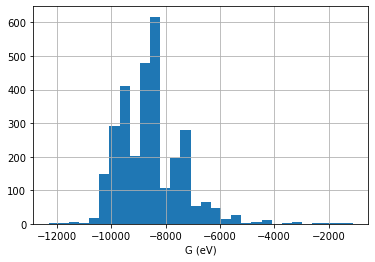

In [40]:
G_train = [val.y[0][10].numpy() for val in train_dataset]
G_train = pd.Series(G_train, name='G (train) (eV)',dtype=np.float64)
stats_G_train = G_train.describe()
display(G_train.describe())

G_test = [val.y[0][10].numpy() for val in test_dataset]
G_test = pd.Series(G_test, name='G (eV)', dtype=np.float64)
stats_G_test = G_test.describe()

ax = G_train.hist(bins=30)
_ = ax.set_xlabel('G (eV)')

def norm_energy(val,stats):
  return (val-stats.mean())/stats.std()

def unnorm_energy(val,stats):
  return val*stats.std()+stats.mean()

Se importan los datos hacia Tensorflow

In [93]:
def generator():
    for val in train_dataset:
        yield val.pos.numpy(), val.z.numpy(), norm_energy(val.y[0][10].numpy(), stats_G_train)

def generator_val():
    for val in val_dataset:
        yield val.pos.numpy(), val.z.numpy(), norm_energy(val.y[0][10].numpy(), stats_G_train)

def generator_test():
    for val in test_dataset:
        yield val.pos.numpy(), val.z.numpy(), val.y[0][10].numpy()

train_data = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    ),
).shuffle(buffer_size=3000)

val_data = tf.data.Dataset.from_generator(
    generator_val,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    ),
).shuffle(buffer_size=1000)

test_data = tf.data.Dataset.from_generator(
    generator_test,
    output_signature=(
        tf.TensorSpec(shape=(None, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.float32)
    ),
).shuffle(buffer_size=1000)


Un grafico de algunas moleculas que se busca encontrar su energia G

Mean: -10563.248 (kcal/mol) 
Std: 803.868 (kcal/mol) 
Max: -8456.826 (kcal/mol) 
Min: -13389.582 (kcal/mol) 



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


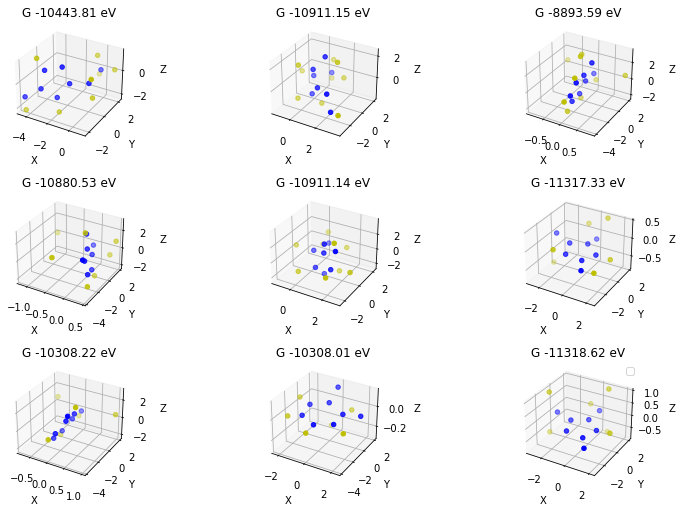

In [94]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), subplot_kw={'projection': '3d'})
axs = axs.flatten()
dict_colors = {1:'y', 2: 'g', 3: 'y', 4: 'y', 5:'y', 6:'b' , 7:'b', 8:'b', 9:'b', 10:'b',
              11:'y', 12:'y', 13:'y', 14:'b', 15:'b', 16:'b', 17:'b', 18:'b', 19:'y', 20:'y'}
def color(val):
  return dict_colors[int(val)]
color_vec = np.vectorize(color)
print(f'Mean: {round(stats_G_test["mean"],3)} (kcal/mol) \nStd: {round(stats_G_test["std"],3)} (kcal/mol) \n\
Max: {round(stats_G_test["max"],3)} (kcal/mol) \nMin: {round(stats_G_test["min"],3)} (kcal/mol) \n')
# get a few examples and plot them
for i, (x, y, z) in enumerate(test_data):
    if i == 9:
        break
    # Graficar los puntos
    axs[i].scatter(x[:, 0], x[:, 1], x[:, 2], c=color_vec(y.numpy()), marker='o')
    num_title = np.around(z.numpy(),1)
    axs[i].set_title(f'G {round(float(z.numpy()),2)} eV')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_zlabel('Z')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.4)
plt.legend()
plt.show()


### Procesando los datos tipo grafo para la red

Para construir el filtro de convolucion "continuo", se requiere una funcion que calcule la distancia de dos nodos dados, `get_edges()` recibe las posiciones y la cantidad maxima de nodos vecinos que puede tener un nodo central. La estrategia es concentrar los $n$ vecinos mas cercanos de un nodo dado, esta funcion devuelve:

*   `-topk.values` : tensor shape $(\cdot ,N)$, que posee las $N$ distancias mas pequenas con respecto al atomo de la fila $i$
*   `topk.indices`: tensor shape $(\cdot ,N)$, que posee los $N$ indices correspondientes a los atomos mas cercanos al de la fila $i$


In [73]:
# this decorator speeds up the function by "compiling" it (tracing it)
# to run efficienty
@tf.function(
    reduce_retracing=True,
)
def get_edges(positions, NN, sorted=True):
    M = tf.shape(input=positions)[0] #number of points
    # adjust NN
    NN = tf.minimum(NN, M)
    qexpand = tf.expand_dims(positions, 1)  # add dim extra at 1
    qTexpand = tf.expand_dims(positions, 0)  # add dim extra at 0
    # repeat it to make matrix of all positions
    qtile = tf.tile(qexpand, [1, M, 1]) #repeat M times
    qTtile = tf.tile(qTexpand, [M, 1, 1])
    # subtract them to get distance matrix
    dist_mat = qTtile - qtile
    # mask distance matrix to remove zros (self-interactions)
    dist = tf.norm(tensor=dist_mat, axis=2)
    mask = dist >= 5e-4
    mask_cast = tf.cast(mask, dtype=dist.dtype) #matriz 0 y 1
    # make masked things be really far
    dist_mat_r = dist * mask_cast + (1 - mask_cast) * 1000
    topk = tf.math.top_k(-dist_mat_r, k=NN, sorted=sorted)
    return -topk.values, topk.indices

La informacion del dataset debe ser trabajada para ser usada dentro de la arquitectura, sobre esto ya se tiene la funcion `get_edges()` que calcula los nodos mas cercanos a un nodo dado. Esta informacion de distancia no se puede usar como filtro de forma directa, sino que se trabaja por medio de una rbf como la siguiente:
$$
e_k ( \mathbf{r}_i - \mathbf{r}_j ) = \exp\left(-\gamma \left(d_{ij} - \mu_k\right)^2\right)
$$

$$
 d_{ij} = \left\| \mathbf{r}_i - \mathbf{r}_j \right\|
$$

En especifico lo que se busca entregar a la red es:

- $\mathbf{x}_i^0$ (`y`): Vector que contiene los elementos atomicos que corresponden a los nodos de un grafo dado
- $e_k ( \mathbf{r}_i - \mathbf{r}_j )$ (`edge_features`) : Distancias de cada uno de los nodos del grafo, evaluadas sobre la funcion $e_k$
- `edge_i`: Tensor que dado un nodo $i$ tiene los $n$ nodos mas cercanos a este

In [146]:
MAX_DEGREE = 10 #cantidad de vecinos a un atomo dado
EDGE_FEATURES = 300 #cantidad de caracteristicas por distancia
MAX_R = 30 #hiperparametro de rbf

gamma = 10
mu = np.linspace(0, MAX_R, EDGE_FEATURES)


def rbf(r):
    return tf.exp(-gamma * (r[..., tf.newaxis] - mu) ** 2)


def make_graph(x, y, z):
    edge_r, edge_i = get_edges(x, MAX_DEGREE)
    edge_features = rbf(edge_r)
    z =  tf.reshape(z, (-1,))
    return (y, edge_features, edge_i), z

graph_train_data = train_data.map(make_graph)
graph_val_data = val_data.map(make_graph)
graph_test_data = test_data.map(make_graph)




### Arquitectura de SchNet en Tensorflow

In [153]:
def ssp(x):
    # shifted softplus activation
    return tf.math.log(0.5 * tf.math.exp(x) + 0.5)


def make_h1(units):
    return tf.keras.Sequential([tf.keras.layers.Dense(units)])


def make_h2(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp),
         tf.keras.layers.Dense(units, activation=ssp)])

def make_h3(units):
    return tf.keras.Sequential(
        [tf.keras.layers.Dense(units, activation=ssp), tf.keras.layers.Dense(units)]
    )

class SchNetModel(tf.keras.Model):
    """Implementation of SchNet Model"""

    def __init__(self, gnn_blocks, channels, **kwargs):
        super(SchNetModel, self).__init__(**kwargs)
        self.gnn_blocks = gnn_blocks

        # build our layers
        self.embedding = tf.keras.layers.Embedding(20, channels) #transform to 1 to channels
        self.h1s = [make_h1(channels) for _ in range(self.gnn_blocks)]
        self.h2s = [make_h2(channels) for _ in range(self.gnn_blocks)]
        self.h3s = [make_h3(channels) for _ in range(self.gnn_blocks)]
        self.readout_l1 = tf.keras.layers.Dense(channels // 2, activation=ssp)
        self.readout_l2 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        nodes, edge_features, edge_i = inputs
        # turn node types as index to features
        nodes = self.embedding(nodes)
        for i in range(self.gnn_blocks):
            v_sk = tf.gather(nodes, edge_i) #choose closest atoms (sender to k)
            e_k = self.h1s[i](v_sk) * self.h2s[i](edge_features) #calcular edge_k 
            e_i = tf.reduce_sum(e_k, axis=1) #aggregation function (sum over all edges)
            nodes += self.h3s[i](e_i) #update node feature. The edge feature are not updated
        # readout now
        nodes = self.readout_l1(nodes)
        nodes = self.readout_l2(nodes)
        return tf.reduce_mean(nodes, axis=0) #aggregate over all nodes



In [158]:
small_schnet = SchNetModel(3, 64) #3 interactions block, 64 channels

### Entrenamiento

Queda unicamente entrenar el modelo!, se elige la metrica mae (Mean Absolute Error) para comparar luego con SchNet, notar que aca el batchsize es 1!, esto en la practica no es comun pero se deja asi solo para no complicar el ejemplo

In [159]:
small_schnet.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4), loss='mse', metrics=['mae']
)
# Train your model
result = small_schnet.fit(graph_train_data, validation_data=graph_val_data, epochs=20)

Epoch 1/20
   2992/Unknown 25s 6ms/step - loss: 0.0525 - mae: 0.1688

/home/ian/anaconda3/envs/implicitgnn/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3000/3000 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - loss: 0.0524 - mae: 0.1687 - val_loss: 0.0148 - val_mae: 0.0808
Epoch 2/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0135 - mae: 0.0919 - val_loss: 0.0154 - val_mae: 0.0869
Epoch 3/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0112 - mae: 0.0837 - val_loss: 0.0122 - val_mae: 0.0820
Epoch 4/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0088 - mae: 0.0722 - val_loss: 0.0139 - val_mae: 0.0810
Epoch 5/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0075 - mae: 0.0672 - val_loss: 0.0136 - val_mae: 0.0809
Epoch 6/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 0.0062 - mae: 0.0610 - val_loss: 0.0084 - val_mae: 0.0651
Epoch 7/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0061 - mae: 0.0609 - val_loss: 0.0188 - val_mae: 0.1037
Epoch 8/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - loss: 0.0055 - mae: 0.0575 - val_loss: 0.0075 - val_mae: 0.0605
Epoch 9/20
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 2

Se muestra el grafico de perdida segun epocas 

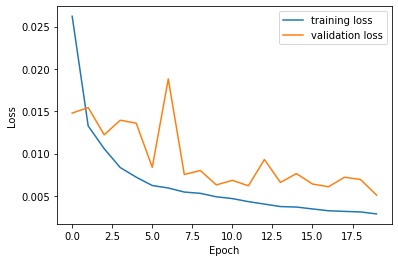

In [160]:
plt.plot(result.history["loss"], label="training loss")
plt.plot(result.history["val_loss"], label="validation loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

Luego se evalua en base al test set, considerando quitar la normalizacion hecha sobre los datos

In [161]:
mae = 0
for i, (x, y) in enumerate(graph_test_data):
    yhat = unnorm_energy(small_schnet(x), stats_G_train)
    mae += abs(yhat - y.numpy())
print(f'MAE (Test set): {mae/(i+1)}')

MAE (Test set): [500.0401]


Como referencia MAE = 0.59 con 50k datos se reporta en el paper de Schnet. Se grafica la estructura de los datos, la energia predicha y la prediccion hecha por la red

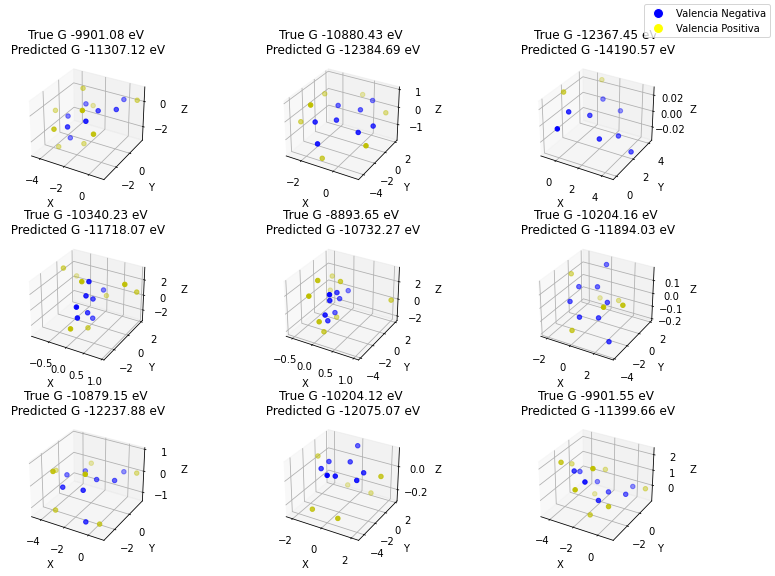

In [164]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8), subplot_kw={'projection': '3d'})
axs = axs.flatten()
dict_colors = {1:'y', 2: 'g', 3: 'y', 4: 'y', 5:'y', 6:'b' , 7:'b', 8:'b', 9:'b', 10:'g',
              11:'y', 12:'y', 13:'y', 14:'b', 15:'b', 16:'b', 17:'b', 18:'g', 19:'y', 20:'y'}
def color(val):
  return dict_colors[int(val)]
color_vec = np.vectorize(color)

for i, (x, y, z) in enumerate(test_data):
    if i == 9:
        break
    # Graficar los puntos
    axs[i].scatter(x[:, 0], x[:, 1], x[:, 2], c=color_vec(y.numpy()),marker='o')
    num_title = np.around(z.numpy(),1)
    (xi), eta = make_graph(x, y, z)
    gnn_energy = unnorm_energy(small_schnet(xi), stats_G_test)
    axs[i].set_title(f'True G {round(float(z.numpy()),2)} eV\n Predicted G {round(float(gnn_energy),2)} eV')
    axs[i].set_xlabel('X')
    axs[i].set_ylabel('Y')
    axs[i].set_zlabel('Z')

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.05, wspace=0.4, hspace=0.4)
# Añadir leyenda personalizada
blue_patch = plt.Line2D([0], [0], marker='o', color='w', label='Valencia Negativa', markerfacecolor='blue', markersize=10)
yellow_patch = plt.Line2D([0], [0], marker='o', color='w', label='Valencia Positiva', markerfacecolor='yellow', markersize=10)
fig.legend(handles=[blue_patch, yellow_patch], loc='upper right')

plt.show()